# delay_remapping.ipynb

In [2]:
# General
import sys
import os
import os.path as op
from time import time
import warnings
from collections import OrderedDict as od
from importlib import reload
from glob import glob
import itertools
import h5py

# Scientific
import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999
import scipy.io as sio

# Stats
import scipy as sp
import scipy.stats as stats
from scipy.spatial.distance import mahalanobis
import statsmodels.api as sm
from statsmodels.formula.api import ols
import random
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib_venn import venn2
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as patches
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.major.width'] = 0.8
mpl.rcParams['ytick.major.width'] = 0.8
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.labelpad'] = 8
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 16
mpl.rcParams['figure.figsize'] = (10, 4) 
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42

# Personal
sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects/manning_replication')
sys.path.append('/home1/dscho/code/projects')
import data_io as dio
import array_operations as aop
from eeg_plotting import plot_trace, plot_trace2
from time_cells import spike_sorting, spike_preproc, events_preproc, time_bin_analysis, time_cell_plots, remapping

font = {'tick': 12,
        'label': 14,
        'annot': 12,
        'fig': 16}

# Colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+3)[c],
          'k']
cmap = sns.palettes.blend_palette((colors[0], 
                                   'w',
                                   colors[1]), 501)

colws = od([('1', 6.55),
            ('2-1/2', 3.15),
            ('2-1/3', 2.1),
            ('2-2/3', 4.2),
            ('3', 2.083),
            ('4', 1.525),
            ('5', 1.19),
            ('6', 0.967),
            (1, 2.05),
            (2, 3.125),
            (3, 6.45),
            ('nat1w', 3.50394),
            ('nat2w', 7.20472),
            ('natl', 9.72441)])

proj_dir = '/home1/dscho/projects/time_cells'

In [3]:
# Get sessions.
sessions = np.unique([op.basename(f).split('-')[0] 
                      for f in glob(op.join(proj_dir, 'analysis', 'events', '*.pkl'))])
print('{} subjects, {} sessions'.format(len(np.unique([x.split('_')[0] for x in sessions])), len(sessions)))

8 subjects, 10 sessions


In [10]:
circle1 = circit(0.7, 'd')
circle2 = circit(circle1['a'], 'a', scale=63/74)

print('Delay1: {}'.format(circle1))
print('Delay2: {}'.format(circle2))

Delay1: {'r': 0.35, 'd': 0.7, 'a': 0.3848451000647496, 'c': 2.199114857512855}
Delay2: {'r': 0.32294045974535385, 'd': 0.6458809194907077, 'a': 0.3276383960010706, 'c': 2.029094751765828}


In [4]:
load_single_file = True

start_time = time()

# Load all time OLS result files.
filename = op.join(proj_dir, 'analysis', 'unit_to_behav', 'tmp',
                   'ols-time_bin-model_pairs-420units.pkl')
if load_single_file and op.exists(filename):
    ols_pairs = dio.open_pickle(filename)
else:
    ols_pairs_files = glob(op.join(proj_dir, 'analysis', 'unit_to_behav', '*-time_bin-model_pairs.pkl'))
    print('Found OLS outputs for {} neurons'.format(len(ols_pairs_files)))

    warnings.filterwarnings('ignore')
    bad_files = []
    ols_pairs = pd.DataFrame([])
    for filename in ols_pairs_files:
        try:
            ols_pairs = pd.concat((ols_pairs, dio.open_pickle(filename)))
        except:
            bad_files.append(filename)
    ols_pairs = ols_pairs.sort_values(['subj_sess', 'neuron']).reset_index(drop=True)
    warnings.resetwarnings()

    # Restrict dataframe rows to navigation periods.
    keep_cols = ['subj_sess', 'neuron', 'gameState', 'testvar', 'full', 'llf_full', 'lr', 'z_lr', 'emp_pval']
    # ols_pairs = ols_pairs.query("(gameState==['Encoding', 'Retrieval'])")[keep_cols].reset_index(drop=True)
    ols_pairs = ols_pairs[keep_cols].reset_index(drop=True)

    # Organize categorical columns.
    test_vars = ['time', 'place', 'head_direc', 'gold_in_view', 'base_in_view']
    test_var_cat = pd.CategoricalDtype(test_vars, ordered=True)
    ols_pairs['testvar'] = ols_pairs['testvar'].astype(test_var_cat)

    full_models = ['time', 'time_place', 'full']
    full_model_cat = pd.CategoricalDtype(full_models, ordered=True)
    ols_pairs['full'] = ols_pairs['full'].astype(full_model_cat)

    # Add new columns.
    roi_map = spike_preproc.roi_mapping(n=3)
    val_map = od([('hem', []),
                  ('roi', []),
                  ('roi_gen', []),
                  ('spike_mat'        , []),
                  ('mean_frs'         , []),
                  ('sem_frs'          , []),
                  ('fr_mean'          , []),
                  ('fr_max'           , []),
                  ('fr_max_ind'       , []),
                  ('sparsity'         , [])])
    for idx, row in ols_pairs.iterrows():
        if 'event_spikes' not in dir():
            event_spikes = time_bin_analysis.load_event_spikes(row['subj_sess'], verbose=False)
        elif event_spikes.subj_sess != row['subj_sess']:
            event_spikes = time_bin_analysis.load_event_spikes(row['subj_sess'], verbose=False)
        hemroi = spike_preproc.roi_lookup(row['subj_sess'], row['neuron'].split('-')[0])
        hem = hemroi[0]
        roi = hemroi[1:]
        roi_gen = roi_map.get(roi, np.nan)
        spike_mat = event_spikes.get_spike_mat(row['neuron'], row['gameState'])
        mean_frs = time_bin_analysis.get_mean_frs(spike_mat) * 2
        sem_frs = time_bin_analysis.get_sem_frs(spike_mat) * 2
        fr_mean = np.mean(mean_frs.values)
        fr_max = np.max(mean_frs.values)
        fr_max_ind = np.argmax(mean_frs.values)
        sparsity = time_bin_analysis.get_sparsity(spike_mat)

        val_map['hem'].append(hem)
        val_map['roi'].append(roi)
        val_map['roi_gen'].append(roi_gen)
        val_map['spike_mat'].append(spike_mat.values.tolist())
        val_map['mean_frs'].append(mean_frs.tolist())
        val_map['sem_frs'].append(sem_frs.tolist())
        val_map['fr_mean'].append(fr_mean)
        val_map['fr_max'].append(fr_max)
        val_map['fr_max_ind'].append(fr_max_ind)
        val_map['sparsity'].append(sparsity)

    ols_pairs.insert(0, 'subj', ols_pairs['subj_sess'].apply(lambda x: x.split('_')[0]))
    ols_pairs.insert(2, 'subj_sess_unit', ols_pairs.apply(lambda x: '{}-{}'.format(x['subj_sess'], x['neuron']), axis=1))
    ols_pairs.insert(4, 'hem', val_map['hem'])
    ols_pairs.insert(5, 'roi', val_map['roi'])
    ols_pairs.insert(6, 'roi_gen', val_map['roi_gen'])
    for col_name in val_map:
        if col_name not in ols_pairs:
            ols_pairs[col_name] = val_map[col_name]
    roi_gen_cat = ['Hippocampus', 'MTL', 'Cortex']
    ols_pairs['roi_gen'] = ols_pairs['roi_gen'].astype(pd.CategoricalDtype(roi_gen_cat, ordered=True))
    ols_pairs.insert(ols_pairs.columns.tolist().index('roi_gen')+1, 'roi_gen2', ols_pairs['roi_gen'].tolist())
    ols_pairs.loc[ols_pairs['roi_gen']=='Hippocampus', 'roi_gen2'] = 'MTL'
    ols_pairs['roi_gen2'] = ols_pairs['roi_gen2'].astype(pd.CategoricalDtype(['MTL', 'Cortex'], ordered=True))

    # Test significance.
    alpha = 0.05
    ols_pairs['sig'] = False
    ols_pairs.loc[((ols_pairs['emp_pval']<alpha)), 'sig'] = True
    ols_pairs['sig_holm'] = ols_pairs.groupby(['subj_sess_unit', 'gameState', 'full'])['emp_pval'].transform(lambda x: sm.stats.multipletests(x, alpha, method='holm')[0])

    print('{} bad files'.format(len(bad_files)))
    
print('ols_pairs:', ols_pairs.shape)

print('Done in {:.1f}s'.format(time() - start_time))

ols_pairs: (6720, 24)
Done in 0.8s


In [5]:
def calc_time_field(v,
                    z_thresh=2):
    """Return the time field given a Z-scored firing rate vector.
    
    The time field is given by contiguous time bins surrounding
    the maximum Z-scored firing rate that are greater than
    z_thresh. If the maximum firing rate is less than z_thresh,
    a v-length vector of zeros is returned.
    """
    time_field = np.zeros(len(v))
    peak = v.argmax()
    
    # Check that the firing rate peak > z_thresh.
    if v[peak]<=z_thresh:
        return time_field
    else:
        time_field[peak] = 1
    
    # Move backwards from the peak firing rate.
    for iBin in range(peak, -1, -1):
        if v[iBin]>z_thresh:
            time_field[iBin] = 1
        else:
            break
    
    # Move forwards from the peak firing rate.
    for iBin in range(peak, len(time_field)):
        if v[iBin]>z_thresh:
            time_field[iBin] = 1
        else:
            break
    
    return time_field

In [7]:
all_cells = ols_pairs['subj_sess_unit'].unique()
delay_time_cells = ols_pairs.query("(sig==True) & (gameState==['Delay1', 'Delay2'])")['subj_sess_unit'].unique()
delay_time_cells.size, all_cells.size, delay_time_cells.size / all_cells.size

(117, 420, 0.2785714285714286)

In [8]:
# Determine which delay time cells significantly remapped between Delay 1 and 2
# by comparing the mean difference in firing rate cosine similarity between
# within-delay vs. between-delay trial pairs.
n_perm = 1000
alpha = 0.05

start_time = time()

all_cells = ols_pairs['subj_sess_unit'].unique()
delay_time_cells = ols_pairs.query("(gameState==['Delay1', 'Delay2']) & (sig==True)")['subj_sess_unit'].unique()
grp = (ols_pairs.query("(gameState==['Delay1', 'Delay2'])")
       .sort_values(['subj_sess', 'neuron', 'gameState'])
       .query("(subj_sess_unit=={})".format(list(delay_time_cells)))
       .groupby(['subj_sess_unit']))

time_remapping = []
for neuron, _df in grp:
    assert len(_df) == 2
    assert _df.iloc[0]['gameState'] == 'Delay1'
    assert _df.iloc[1]['gameState'] == 'Delay2'
    
    subj_sess = _df.iloc[0]['subj_sess']    
    nsig = _df['sig'].sum()
    assert nsig in [0, 1, 2]
    
    if 'event_spikes' not in dir():
        event_spikes = time_bin_analysis.load_event_spikes(subj_sess, verbose=False)
    elif event_spikes.subj_sess != subj_sess:
        event_spikes = time_bin_analysis.load_event_spikes(subj_sess, verbose=False)
    
    
    spike_mats = od([])
    for _, row in _df.iterrows():
        spike_mats[row['gameState']] = event_spikes.get_spike_mat(row['neuron'], row['gameState'], column='time_step')
    
    # Get Delay1 to Delay2 firing vector sims.
    pairwise_sims = remapping.trial_pair_remapping(spike_mats)
    mean_sims = {k : np.mean(v) for k, v in pairwise_sims.items()}
    mean_sims['within'] = np.max((mean_sims['Delay1'], mean_sims['Delay2']))
    asym = mean_sims['within'] - mean_sims['between']
    
    # Compute the null distribution.
    pairwise_sims_vec = np.concatenate([pairwise_sims['Delay1'],
                                        pairwise_sims['Delay2'],
                                        pairwise_sims['between']]) # cond x trial_pair
    divs = np.cumsum((len(pairwise_sims['Delay1']), len(pairwise_sims['Delay2']), len(pairwise_sims['between'])))[:2]
    asyms_null = []
    for iPerm in range(n_perm):
        np.random.shuffle(pairwise_sims_vec)
        mean_sims_null = dict(zip(['Delay1', 'Delay2', 'between'], 
                                  [np.mean(x) for x in np.split(pairwise_sims_vec, divs)]))
        mean_sims_null['within'] = np.max((mean_sims_null['Delay1'], mean_sims_null['Delay2']))
        asyms_null.append(mean_sims_null['within'] - mean_sims_null['between'])
    asyms_null = np.array(asyms_null)
    
    asym_z = (asym - np.mean(asyms_null)) / np.std(asyms_null)
    if asym_z > 0:
        asym_z_sign = 1
    elif asym_z == 0:
        asym_z_sign = 0
    else:
        asym_z_sign = -1
    pval_ind = np.sum(np.abs(asyms_null) >= np.abs(asym))
    pval = (1 + pval_ind) / (1 + n_perm)
    
    # Figure out which trial phase (Delay 1 or Delay 2) has stronger time coding.
    # (If only one trial phase is significant, take that one. Otherwise, take whichever
    # has the highest info score). Then add time coding info for the stronger trial phase.
    z_lr_diff = np.abs(np.diff(_df['z_lr']))[0]
    if nsig == 1:
        row = _df.query("(sig==True)").iloc[0]
    else:
        row = _df.sort_values('z_lr', ascending=False).iloc[0]
    game_state = row['gameState']
    z_lr = row['z_lr']
    fr_max_ind = row['fr_max_ind']
    time_remapping.append([neuron, subj_sess, nsig, z_lr_diff, game_state, z_lr,
                           fr_max_ind, asym, asym_z, asym_z_sign, pval_ind, pval])
        
time_remapping = pd.DataFrame(time_remapping, columns=['neuron', 'subj_sess', 'nsig', 'z_lr_diff', 'gameState', 'z_lr', 
                                                         'fr_max_ind', 'asym', 'asym_z', 'asym_z_sign', 'pval_ind', 'pval'])
time_remapping['sig'] = time_remapping['pval'] < alpha
time_remapping['asym_z_cat'] = 0
time_remapping.loc[(time_remapping['sig']==True) & (time_remapping['asym_z_sign']==-1), 'asym_z_cat'] = 1
time_remapping.loc[(time_remapping['sig']==True) & (time_remapping['asym_z_sign']==1), 'asym_z_cat'] = 2
time_remapping.loc[(time_remapping['asym_z_cat']==1), 'sig'] = False
time_remapping['dummy'] = 0
unit_to_roi_map = ols_pairs[['subj_sess_unit', 'roi_gen']].drop_duplicates().set_index('subj_sess_unit')['roi_gen'].to_dict()
time_remapping.insert(2, 'roi_gen', time_remapping['neuron'].apply(lambda x: unit_to_roi_map[x]))

print('time_remapping: {}'.format(time_remapping.shape))
print('Dont in {:.1f}s'.format(time() - start_time))

/home1/dscho/code/general/array_operations.py:25: RuntimeWarning: invalid value encountered in true_divide
  return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))


Loading saved Events file


/home1/dscho/code/general/array_operations.py:25: RuntimeWarning: invalid value encountered in true_divide
  return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))


time_remapping: (117, 16)
Dont in 33.9s


In [9]:
print(stats.pearsonr(time_remapping['z_lr'], time_remapping['asym_z']))
time_remapping.groupby('asym_z_cat').agg({'neuron': len, 'z_lr': lambda x: '{:.1f} ± {:.1f}'.format(np.mean(x), stats.sem(x))})

(0.06217327666849489, 0.5054551909161639)


,neuron,z_lr
asym_z_cat,,
0,67,3.6 ± 0.3
1,2,2.2 ± 0.1
2,48,3.9 ± 0.3


In [10]:
time_remapping.groupby('roi_gen')['asym_z_cat'].apply(lambda x: '{}/{}; {:.1%}'.format(np.sum(x==2), len(x), np.mean(x==2)))

roi_gen
Cortex         21/54; 38.9%
Hippocampus    12/20; 60.0%
MTL            15/43; 34.9%
Name: asym_z_cat, dtype: object

In [11]:
ctab = [[12, 15, 21],
        [20, 43, 54]]
stats.chi2_contingency(ctab)

(1.4333554376657824,
 0.4883720730670287,
 2,
 array([[ 9.30909091, 16.87272727, 21.81818182],
        [22.69090909, 41.12727273, 53.18181818]]))

In [22]:
time_remapping['_fr_max_ind'] = np.floor(time_remapping['fr_max_ind'] / 2)
time_remapping.groupby('_fr_max_ind')['asym_z_cat'].apply(lambda x: '{}/{}; {:.1%}'.format(np.sum(x==2), len(x), np.mean(x==2)))

_fr_max_ind
0.0    16/41; 39.0%
1.0     8/22; 36.4%
2.0      2/5; 40.0%
3.0     2/10; 20.0%
4.0      3/5; 60.0%
5.0      3/6; 50.0%
6.0      2/4; 50.0%
7.0       0/6; 0.0%
8.0      4/7; 57.1%
9.0     8/11; 72.7%
Name: asym_z_cat, dtype: object

In [23]:
time_remapping.groupby(['asym_z_cat']).agg({'neuron': len, 'fr_max_ind': [np.mean, np.std, stats.sem]})

neuron fr_max_ind                    
              len       mean       std       sem
asym_z_cat                                      
0              67   5.582090  5.944565  0.726244
1               2   3.500000  3.535534  2.500000
2              48   7.145833  7.255195  1.047197

In [25]:
time_remapping.groupby('nsig').agg({'neuron': lambda x: '{}/{} ({:.1%})'.format(len(x), all_cells.size, len(x)/all_cells.size)})

,neuron
nsig,
1,97/420 (23.1%)
2,20/420 (4.8%)


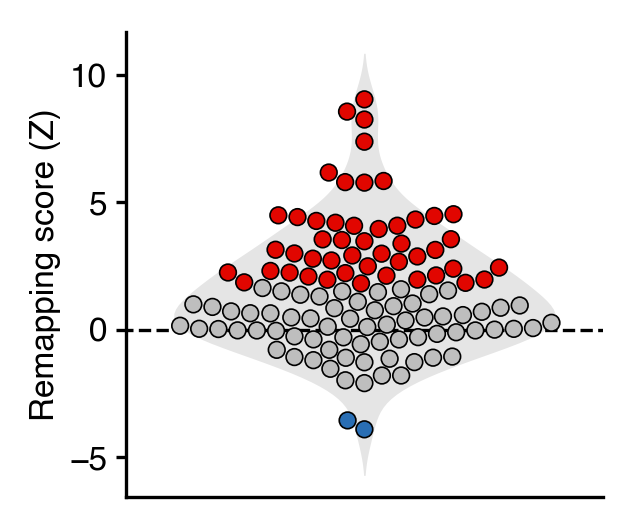

In [26]:
savefig = 0
overwrite = 0
dpi = 1200

fig, ax = plt.subplots(1, 1, figsize=(colws[1], colws[1]), dpi=300)
#ax = np.ravel(ax)

font = {'tick': 8, 'label': 8, 'annot': 8, 'fig': 10}
_cmap = ['#bebebe', '#296eb4', '#e10600']

i = 0
ax = sns.violinplot(x='dummy', y='asym_z', data=time_remapping,
                    inner=None, color='k',  saturation=100, zorder=0, ax=ax)

poly = ax.collections[0]
poly.set_alpha(0.1)
poly.set_linewidth(0)
ax = sns.swarmplot(x='dummy', y='asym_z', hue='asym_z_cat', data=time_remapping,
                   palette=_cmap, size=4, 
                   edgecolor='k', linewidth=0.4, zorder=2, ax=ax)
ax.get_legend().remove()
ax.tick_params(axis='y', which='both', length=2.5, pad=2, labelsize=font['tick'])
ax.set_xticks([])
ax.set_xlabel('')
ax.set_ylabel('Remapping score (Z)', fontsize=font['label'], labelpad=2)
plt.hlines(0, -10, 10, color='k', linewidth=0.8, linestyle='--', zorder=1)

if savefig:
    n_neurons = time_remapping['neuron'].unique().size
    filename = op.join(proj_dir, 'figs', 'plot_remapping',
                       'delay_time_cell_remapping_scores-{}units.pdf'
                       .format(n_neurons))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)

fig.show()

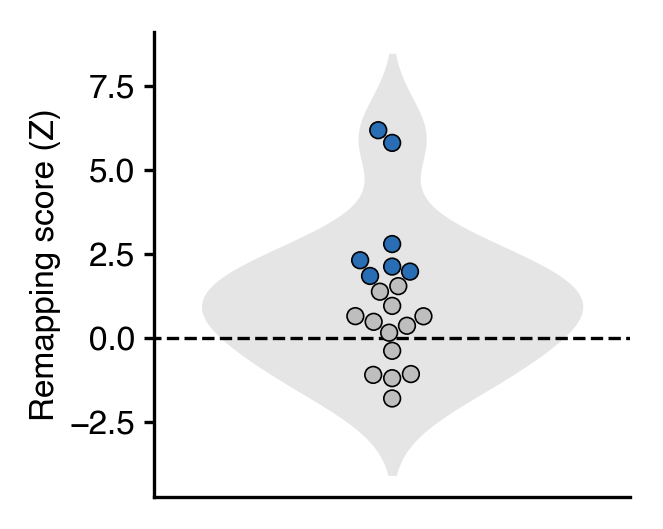

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(colws[1], colws[1]), dpi=300)
#ax = np.ravel(ax)

font = {'tick': 8, 'label': 8, 'annot': 8, 'fig': 10}
_cmap = ['#bebebe', '#296eb4', '#e10600']
_df = time_remapping.query("(nsig==2)")

i = 0
ax = sns.violinplot(x='dummy', y='asym_z', data=_df,
                    inner=None, color='k',  saturation=100, zorder=0, ax=ax)

poly = ax.collections[0]
poly.set_alpha(0.1)
poly.set_linewidth(0)
ax = sns.swarmplot(x='dummy', y='asym_z', hue='asym_z_cat', data=_df,
                   palette=_cmap, size=4, 
                   edgecolor='k', linewidth=0.4, zorder=2, ax=ax)
ax.get_legend().remove()
ax.tick_params(axis='y', which='both', length=2.5, pad=2, labelsize=font['tick'])
ax.set_xticks([])
ax.set_xlabel('')
ax.set_ylabel('Remapping score (Z)', fontsize=font['label'], labelpad=2)
plt.hlines(0, -10, 10, color='k', linewidth=0.8, linestyle='--', zorder=1)

fig.show()

In [28]:
print(time_remapping.sort_values('asym_z', ascending=False).groupby('sig').size())
print('{:.2f} ± {:.2f}, n = {}'.format(np.mean(time_remapping['asym_z']), stats.sem(time_remapping['asym_z']), len(time_remapping['asym_z'])))
print(stats.ttest_1samp(time_remapping['asym_z'], 0))

sig
False    69
True     48
dtype: int64
1.50 ± 0.22, n = 117
Ttest_1sampResult(statistic=6.900324301241092, pvalue=2.918553772932742e-10)


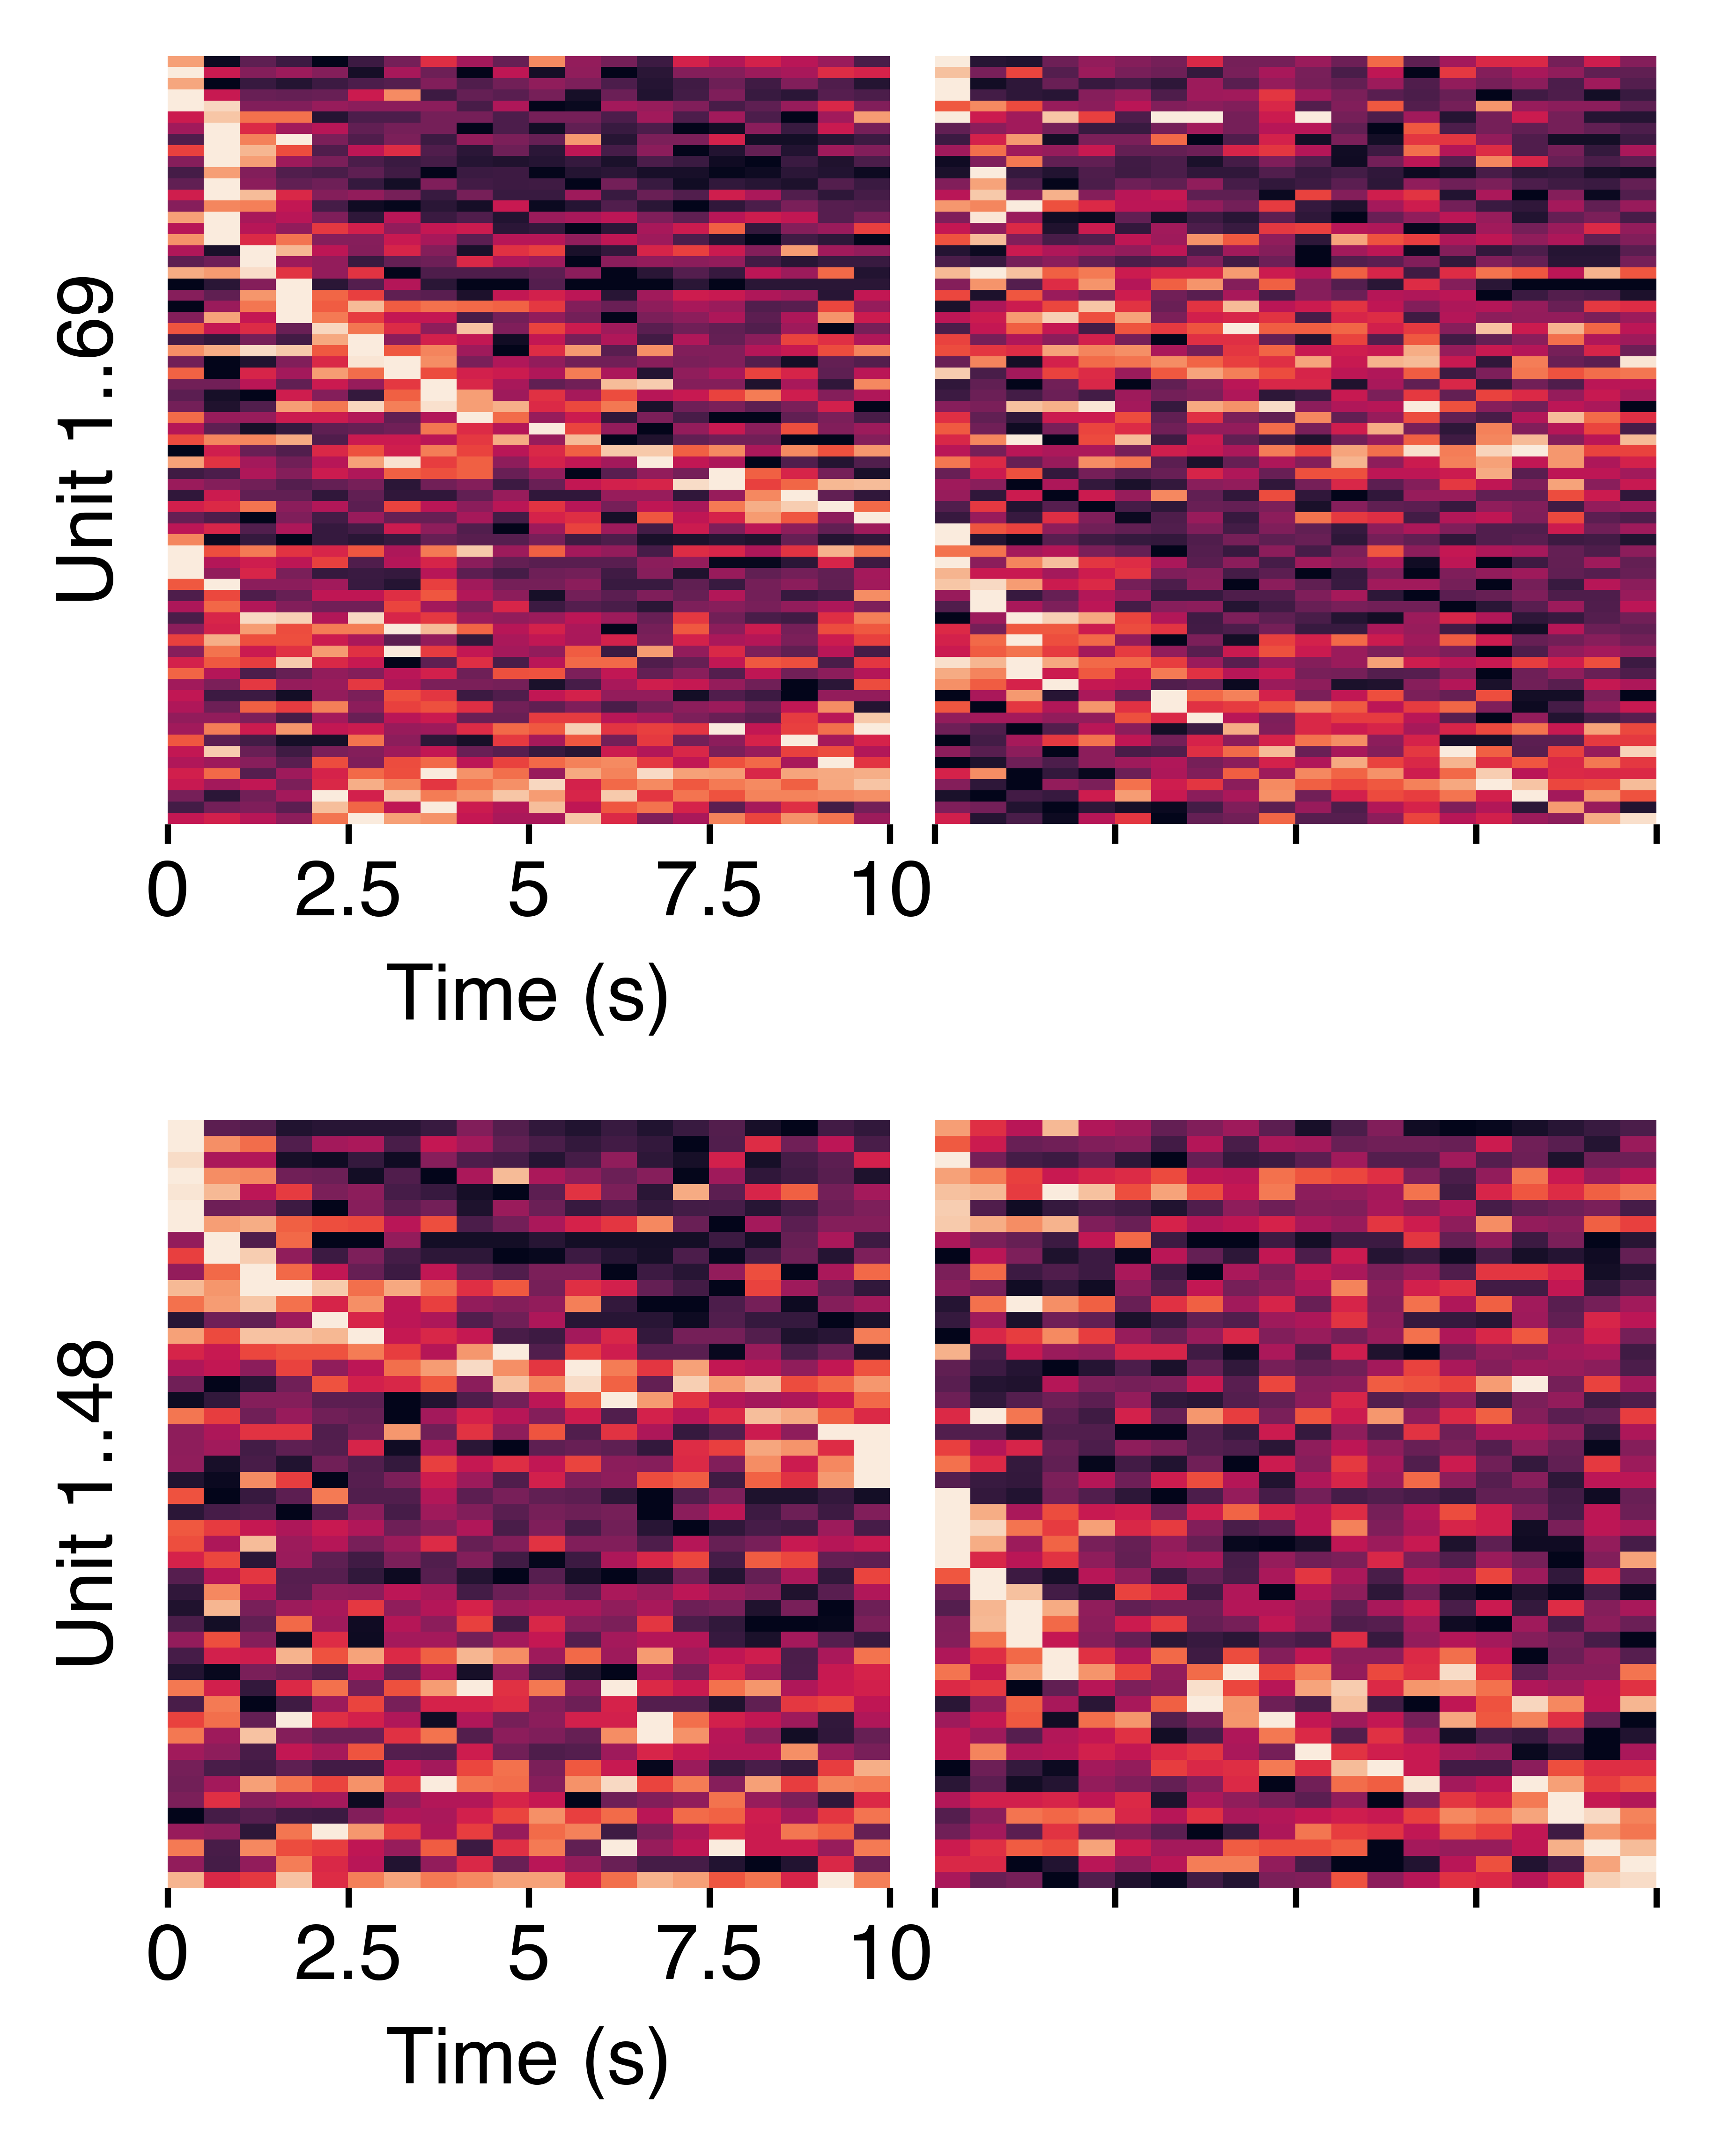

In [29]:
# Plot the mean timecourse for all Delay1 and Delay2 neurons.
savefig = 1
overwrite = 1
remapped = True
figsize = (colws['2-1/2'], colws['2-1/2'] * 1.25)
#figsize = (colws['1'], colws['1']*(grid_shp[0]/grid_shp[1]))
dpi = 1200
font = {'tick': 10, 'label': 10, 'annot': 10, 'fig': 12}
xticks = np.arange(0, 21, 5)
xticklabels = [0, 2.5, 5, 7.5, 10]
plot_title = False
ax_labels = {0: 'Delay1', 1: 'Delay2'}
add_cbar = False
vmin = 0
vmax = 1

plt.close()
fig, ax = plt.subplots(2, 2, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

n_neurons = time_remapping['neuron'].unique().size
for ii, remapped in enumerate([False, True]):
    iax = ii * 2
    
    # Sort neurons that we'll plot firing rates over time for.
    _neurons = time_remapping.query("(sig=={})".format(remapped)).groupby('gameState')['neuron'].apply(list)
    sbt_neurons = []
    for game_state in ['Delay1', 'Delay2']:
        qry = "(gameState=='{}') & (testvar=='time') & (subj_sess_unit=={})".format(game_state, _neurons[game_state])
        sbt_neurons.extend(ols_pairs.query(qry).sort_values(['fr_max_ind', 'sparsity'])['subj_sess_unit'].tolist())
    # _neurons = time_remapping.query("(sig=={})".format(remapped))['neuron'].tolist()
    # qry = "(gameState=='Delay1') & (testvar=='time') & (subj_sess_unit=={})".format(_neurons)
    # sbt_neurons = ols_pairs.query(qry).sort_values(['fr_max_ind', 'sparsity'])['subj_sess_unit'].tolist()
    spikes_by_time = od([('Delay1', []), ('Delay2', [])])
    for neuron in sbt_neurons:
        for game_state in ['Delay1', 'Delay2']:
            qry = "(gameState=='{}') & (testvar=='time') & (subj_sess_unit=='{}')".format(game_state, neuron)
            _df = ols_pairs.query(qry)#
            assert len(_df) == 1
            spikes_by_time[game_state].append(_df.iloc[0]['mean_frs'])

    fr_mat = np.concatenate((np.array(spikes_by_time['Delay1']), np.array(spikes_by_time['Delay2'])), axis=1)
    time_bins = int(fr_mat.shape[1] / 2)
    fr_mat = minmax_scale(fr_mat, axis=1)
    fr_mat = [fr_mat[:, :time_bins], fr_mat[:, time_bins:]]

    # Plot the firing rate heatmaps.
    for imat in range(2):
        ax[iax] = sns.heatmap(fr_mat[imat], vmin=vmin, vmax=vmax, cmap='rocket',
                              square=False, cbar=add_cbar, ax=ax[iax])
        ax[iax].tick_params(axis='x', which='both', length=2.5, pad=2)
        ax[iax].tick_params(axis='y', which='both', length=0, pad=2)
        ax[iax].set_xticks(xticks)
        ax[iax].set_yticks([])
        if iax in [0, 2]:
            ax[iax].set_xticklabels(xticklabels, fontsize=font['tick'], rotation=0)
            ax[iax].set_xlabel('Time (s)', fontsize=font['label'], labelpad=4)
            ax[iax].set_ylabel('Unit 1..{}'.format(fr_mat[0].shape[0]), fontsize=font['label'], labelpad=5)
        else:
            ax[iax].set_xticklabels([], fontsize=font['tick'], rotation=0)
        if plot_title:
            ax[iax].set_title(ax_labels[i], pad=6, fontsize=font['fig'])

        if add_cbar:
            cbar = ax[iax].collections[0].colorbar
            cbar.ax.tick_params(labelsize=font['tick'])
            cbar.set_ticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
            cbar.set_ticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
            cbar.set_label('Norm. firing rate', fontsize=font['label'], labelpad=2)
        
        iax += 1

fig.tight_layout(w_pad=0)

if savefig:
    filename = op.join(proj_dir, 'figs', 'plot_remapping',
                       'delay_time_cell_remapping-{}units-mean_fr_over_time.pdf'
                       .format(n_neurons))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)

fig.show()

In [481]:
time_bins = 20

spikes_by_time = {'sig': [], 'ns': []}
for sig in [True, False]:
    neurons = time_remapping.query("(sig=={})".format(sig))['neuron'].tolist()
    for iUnit in range(len(neurons)):
        subj_sess, chan, unit = neurons[iUnit].split('-')
        neuron = dio.open_pickle(op.join(proj_dir, 'analysis', 'spikes', '{}-CSC{}-unit{}-spikes.pkl'.format(subj_sess, chan, unit)))

        # Load events, firing rate vectors, and time bin indices.
        if ('events' not in locals()) and ('events' not in globals()):
            events = goldmine_behavior.Events(subj_sess)
        elif subj_sess != events.event_times.iloc[0]['subj_sess']:
            events = goldmine_behavior.Events(subj_sess)
        if subj_sess == 'U518_ses1':
            events.event_times = events.event_times.loc[events.event_times['trial']!=31].reset_index(drop=True)

        sum_spikes = []
        for game_state in ['Delay1', 'Delay2']:
            twise_spikes = (events.event_times.query("(gameState=='{}')".format(game_state))['time']
                                              .apply(lambda x: spike_preproc.apply_spike_times_to_fr(x, neuron['spike_times'], sigma=0)).tolist())
            sum_spikes.append(np.sum([[np.nansum(x) for x in np.array_split(x, time_bins)]
                                      for x in twise_spikes], axis=0)) # time_bin; sum over trials
        k = 'sig' if sig else 'ns'
        spikes_by_time[k].append(np.concatenate(sum_spikes)) # time_bin; Delay 1 cat Delay 2 time bins
    spikes_by_time[k] = np.array(spikes_by_time[k])

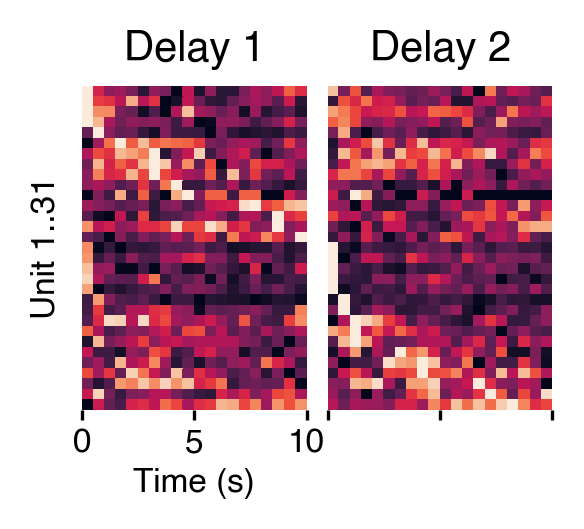

In [484]:
plt.close()
fig, ax = plt.subplots(1, 2, figsize=(colws[1], 0.22 * 8.47), dpi=300)
ax = np.ravel(ax)

font = {'tick': 8, 'label': 8, 'annot': 8, 'fig': 10}

xsort = np.argsort(np.argmax(spikes_by_time['ns'], axis=1))
fr_mat = minmax_scale(spikes_by_time['ns'], axis=1)[xsort, :]
fr_mat = [fr_mat[:, :time_bins], fr_mat[:, time_bins:]]

# Plot the firing rate heatmaps.
ax_labels = {0: 'Delay 1', 1: 'Delay 2'}
add_cbar = False
vmin = 0
vmax = 1
for i in range(2):
    ax[i] = sns.heatmap(fr_mat[i], vmin=vmin, vmax=vmax, cmap='rocket',
                        square=False, cbar=add_cbar, ax=ax[i])
    ax[i].tick_params(axis='x', which='both', length=2.5, pad=2)
    ax[i].tick_params(axis='y', which='both', length=0, pad=2)
    ax[i].set_xticks(np.arange(0, fr_mat[i].shape[1]+1, 10))
    ax[i].set_yticks([])
    if i == 0:
        ax[i].set_xticklabels(np.arange(0, (fr_mat[i].shape[1]+1)/2, 5, dtype=np.int), 
                              fontsize=font['tick'], rotation=0)
        ax[i].set_xlabel('Time (s)', fontsize=font['label'], labelpad=2)
        ax[i].set_ylabel('Unit 1..{}'.format(fr_mat[0].shape[0]), fontsize=font['label'], labelpad=5)
    else:
        ax[i].set_xticklabels([], fontsize=font['tick'], rotation=0)
    ax[i].set_title(ax_labels[i], pad=6, fontsize=font['fig'])

    if add_cbar:
        cbar = ax[i].collections[0].colorbar
        cbar.ax.tick_params(labelsize=font['tick'])
        cbar.set_ticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        cbar.set_ticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        cbar.set_label('Norm. firing rate', fontsize=font['label'], labelpad=2)
        
fig.tight_layout(w_pad=0)

if True:
    fig.savefig(op.join(proj_dir, 'figs', 'delay_time_cells_delay1_delay2_firing_ns-remapping.pdf'), 
                format='pdf', bbox_inches='tight')

In [309]:
iUnit = 0
game_state = 'Delay1'
time_bins = 20

# subj_sess, chan, unit = sig_cells[('delay', 'time')][iUnit].split('-')
#subj_sess, chan, unit = 'U518_ses0', 4, 1
# subj_sess, chan, unit = 'U518_ses1', 38, 1
# subj_sess, chan, unit = 'U530_ses0', 13, 1
# subj_sess, chan, unit = 'U527_ses0', 58, 2
subj_sess, chan, unit = 'U527_ses0', 45, 2
neuron = dio.open_pickle(op.join(proj_dir, 'analysis', 'spikes', '{}-CSC{}-unit{}-spikes.pkl'.format(subj_sess, chan, unit)))

# Load events, firing rate vectors, and time bin indices.
if ('events' not in locals()) and ('events' not in globals()):
    events = goldmine_behavior.Events(subj_sess)
elif subj_sess != events.event_times.iloc[0]['subj_sess']:
    events = goldmine_behavior.Events(subj_sess)
if subj_sess == 'U518_ses1':
    events.event_times = events.event_times.loc[events.event_times['trial']!=31].reset_index(drop=True)

twise_spikes_by_time = od([])
for game_state in ['Delay1', 'Delay2']:
    twise_spikes = (events.event_times.query("(gameState=='{}')".format(game_state))['time']
                                      .apply(lambda x: spike_preproc.apply_spike_times_to_fr(x, neuron['spike_times'], sigma=0)).tolist())
    twise_spikes_by_time[game_state] = np.array([[np.nansum(x) for x in np.array_split(x, time_bins)] for x in twise_spikes]) # trial x time_bin

In [310]:
mean_fr.query("(subj_sess=='{}') & (chan=={}) & (unit=={}) & (game_state==['Delay1', 'Delay2'])".format(subj_sess, chan, unit))

,neuron,subj_sess,subj,sess,chan,unit,fr,hemroi,roi,fr_cat,game_state,obs_fr,obs_fr_max_ind,obs_fr_max,obs_fr_z,obs_fr_z_max_ind,obs_fr_z_max,obs_fr_z_abs_max_ind,obs_fr_z_abs_max,obs_fr_z_abs_max_sign,obs_fr_z_abs_max_above_thresh,time_field,time_field_size,obs_info,obs_info_z,pval_ind,pval,sig,sig_fdr,crit_sig
1560,U527_ses0-45-2,U527_ses0,U527,ses0,45,2,0.623313,REC,EC,fr_by_time,Delay1,"[1.3321504884948367, 1.3625752452272857, 1.424...",2,1.424392,"[1.7997669388035749, 2.3823625812482057, 2.774...",2,2.774921,2,2.774921,1,True,"[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",4.0,0.091119,4.498725,2,0.002997,True,True,True
1561,U527_ses0-45-2,U527_ses0,U527,ses0,45,2,0.623313,REC,EC,fr_by_time,Delay2,"[0.6201093450964343, 0.5308581171096035, 0.409...",11,0.868433,"[-0.0022321816474061037, -0.5634069610126852, ...",11,1.463078,3,-1.686330,-1,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.043149,-0.221273,506,0.506494,False,False,False


In [316]:
start_time = time()

# Identify all within-trial and between-trial pairs.
assert twise_spikes_by_time['Delay1'].shape[0] == twise_spikes_by_time['Delay2'].shape[0]
n_trials = twise_spikes_by_time['Delay1'].shape[0]

within_pairs = [(x, y) for x in range(n_trials) for y in range(n_trials) if (x<y)]
between_pairs = [(x, y) for x in range(n_trials) for y in range(n_trials) if (x<=y)]

# Calculate the Pearson correlation between firing over time vectors for each trial pair.
distances = od([('Delay1', []),
                ('Delay2', []),
                ('between', [])])

for iPair in range(len(within_pairs)):
    t1, t2 = within_pairs[iPair]
    distances['Delay1'].append(stats.pearsonr(twise_spikes_by_time['Delay1'][t1, :],
                                             twise_spikes_by_time['Delay1'][t2, :])[0])
    distances['Delay2'].append(stats.pearsonr(twise_spikes_by_time['Delay2'][t1, :],
                                             twise_spikes_by_time['Delay2'][t2, :])[0])
    
for iPair in range(len(between_pairs)):
    t1, t2 = between_pairs[iPair]
    distances['between'].append(stats.pearsonr(twise_spikes_by_time['Delay1'][t1, :],
                                               twise_spikes_by_time['Delay2'][t2, :])[0])
    
distances['Delay1'] = np.array(distances['Delay1'])[np.isfinite(distances['Delay1'])]
distances['Delay2'] = np.array(distances['Delay2'])[np.isfinite(distances['Delay2'])]
distances['between'] = np.array(distances['between'])[np.isfinite(distances['between'])]

print('Delay1', np.mean(distances['Delay1']), stats.sem(distances['Delay1']))
print('Delay2', np.mean(distances['Delay2']), stats.sem(distances['Delay2']))
print(stats.ttest_ind(distances['Delay1'], distances['Delay2'], equal_var=False))

print('Done in {:.1f}s'.format(time() - start_time))

Delay1 0.021166272546616308 0.009238363533473364
Delay2 -0.009927669393152084 0.009360664550492932
Ttest_indResult(statistic=2.3642377191915394, pvalue=0.018223029665099543)
Done in 0.1s


/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [313]:
start_time = time()

# Calculate the inverse covariance matrix across all Delay 1 and Delay 2 trials.
spike_mat = np.concatenate((twise_spikes_by_time['Delay1'], 
                            twise_spikes_by_time['Delay2']), axis=0) # trial x time_bin
inv_covmat = sp.linalg.inv(np.cov(spike_mat.T)) # time_bin x time_bin

# Identify all within-trial and between-trial pairs.
assert twise_spikes_by_time['Delay1'].shape[0] == twise_spikes_by_time['Delay2'].shape[0]
n_trials = twise_spikes_by_time['Delay1'].shape[0]

within_pairs = [(x, y) for x in range(n_trials) for y in range(n_trials) if (x<y)]
between_pairs = [(x, y) for x in range(n_trials) for y in range(n_trials) if (x<=y)]

# Calculate the Mahalanobis distance between firing over time vectors for each trial pair.
distances = od([('Delay1', []),
                ('Delay2', []),
                ('between', [])])

for iPair in range(len(within_pairs)):
    t1, t2 = within_pairs[iPair]
    distances['Delay1'].append(mahalanobis(twise_spikes_by_time['Delay1'][t1, :],
                                           twise_spikes_by_time['Delay1'][t2, :],
                                           inv_covmat))
    distances['Delay2'].append(mahalanobis(twise_spikes_by_time['Delay2'][t1, :],
                                           twise_spikes_by_time['Delay2'][t2, :],
                                           inv_covmat))
    
for iPair in range(len(between_pairs)):
    t1, t2 = between_pairs[iPair]
    distances['between'].append(mahalanobis(twise_spikes_by_time['Delay1'][t1, :],
                                            twise_spikes_by_time['Delay2'][t2, :],
                                            inv_covmat))
    
print('Delay1', np.mean(distances['Delay1']), stats.sem(distances['Delay1']))
print('Delay2', np.mean(distances['Delay2']), stats.sem(distances['Delay2']))
print(stats.ttest_ind(distances['Delay1'], distances['Delay2'], equal_var=False))

print('Done in {:.1f}s'.format(time() - start_time))

Delay1 6.470626985535602 0.06321649796399922
Delay2 5.566419082836474 0.08017988773811696
Ttest_indResult(statistic=8.855790831619018, pvalue=2.9488370844402827e-18)
Done in 0.0s


In [251]:
#sns.heatmap(np.cov(spike_mat.T))

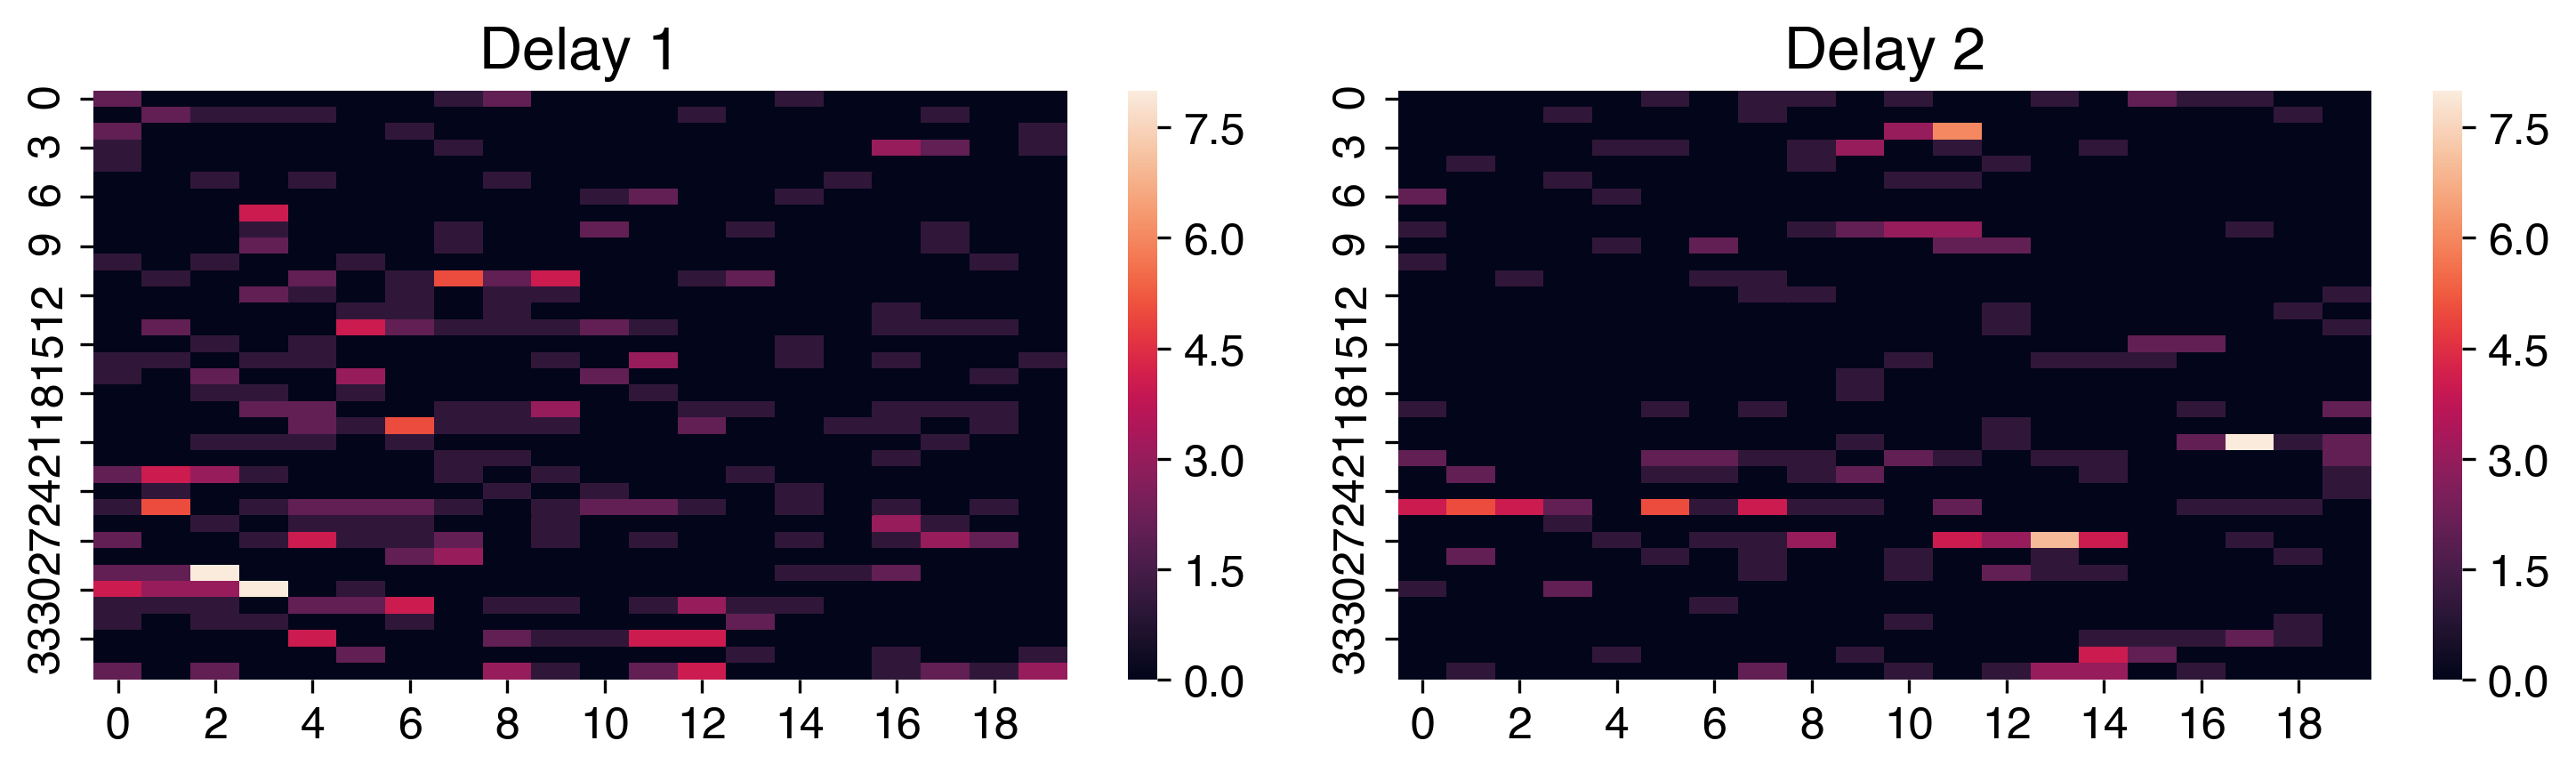

In [315]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), dpi=300)
ax = np.ravel(ax)

i = 0
sns.heatmap(twise_spikes_by_time['Delay1'], ax=ax[i])
ax[i].set_title('Delay 1')

i = 1
sns.heatmap(twise_spikes_by_time['Delay2'], ax=ax[i])
ax[i].set_title('Delay 2')

fig.tight_layout()

Delay1 0.2410552361312156 0.007688825582608449
Delay2 0.14736137858424547 0.008339319350092496
between 0.169295772781115 0.007878699874328036
Delay1 vs. between
Ttest_indResult(statistic=6.51841931967042, pvalue=1.0179188977127066e-10)


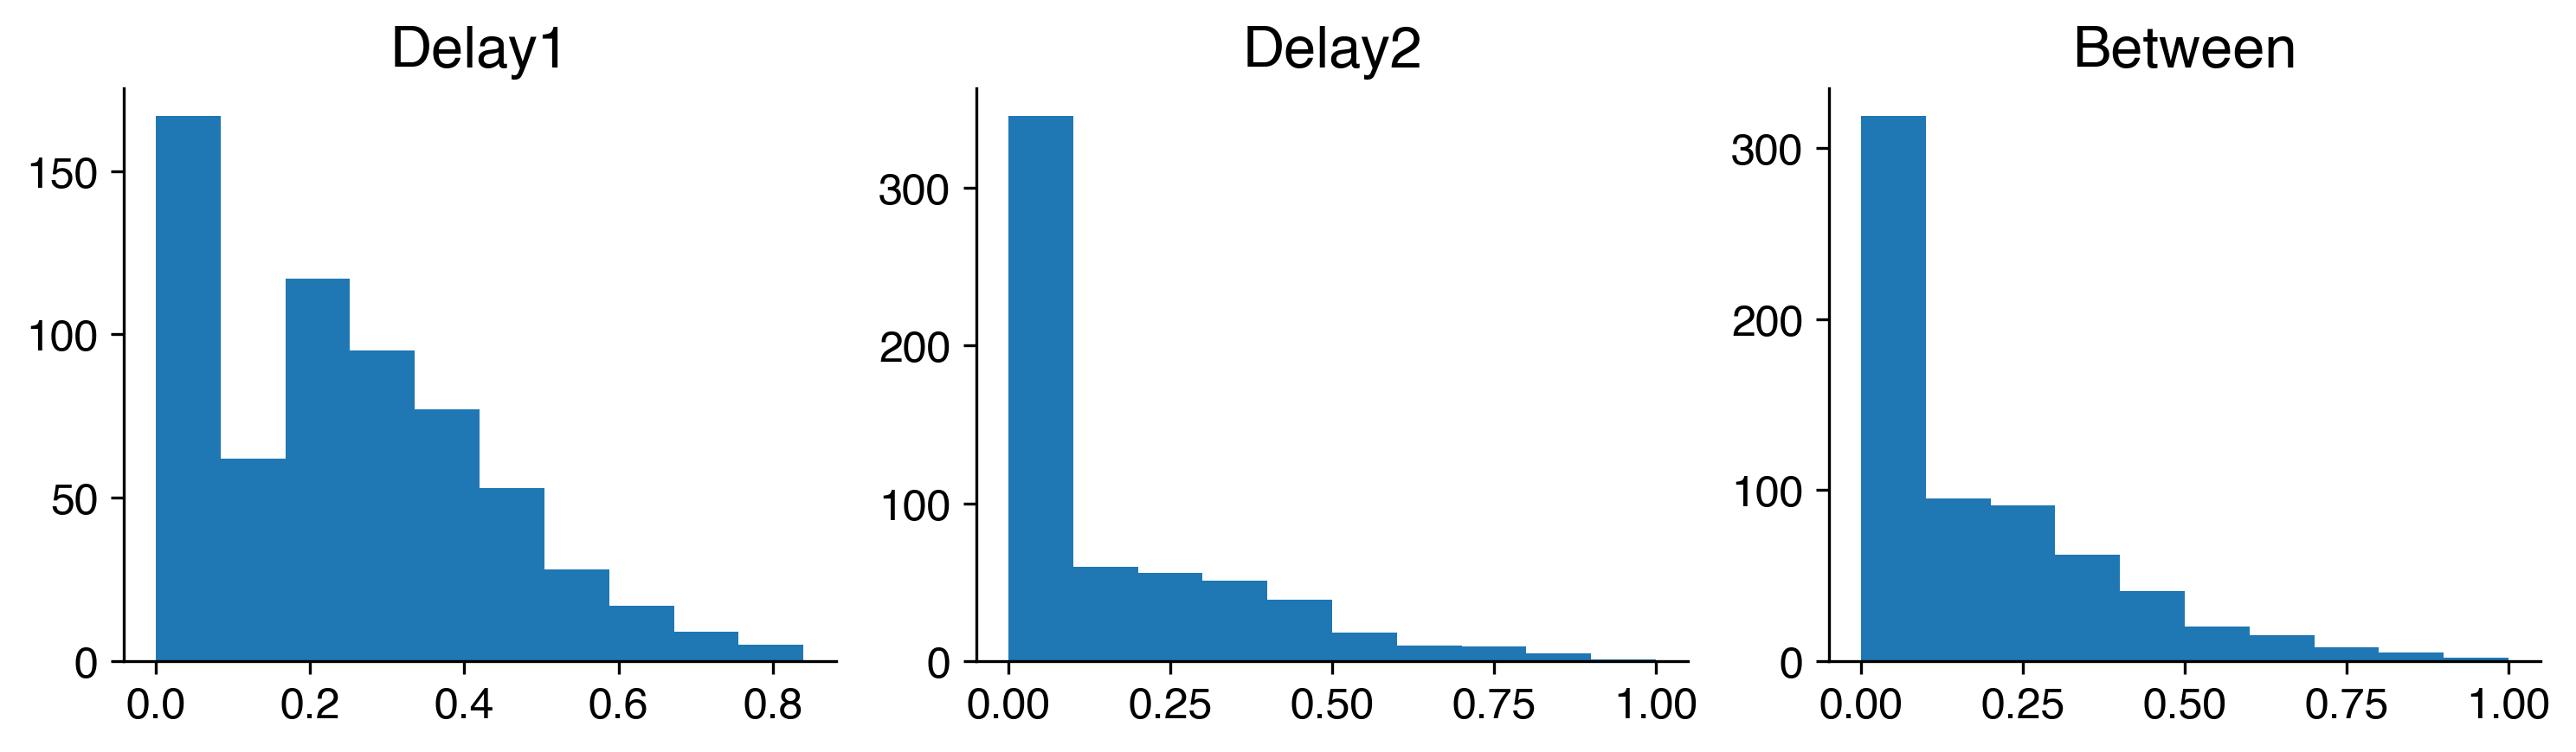

In [319]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3), dpi=300)
ax = np.ravel(ax)

print('Delay1', np.mean(distances['Delay1']), stats.sem(distances['Delay1']))
print('Delay2', np.mean(distances['Delay2']), stats.sem(distances['Delay2']))
print('between', np.mean(distances['between']), stats.sem(distances['between']))
if np.mean(distances['Delay1']) > np.mean(distances['Delay2']):
    print('Delay1 vs. between')
    print(stats.ttest_ind(distances['Delay1'], distances['between'], equal_var=False))
else:
    print('Delay2 vs. between')
    print(stats.ttest_ind(distances['Delay2'], distances['between'], equal_var=False))

i = 0
ax[i].hist(distances['Delay1'])
ax[i].set_title('Delay1')

i = 1
ax[i].hist(distances['Delay2'])
ax[i].set_title('Delay2')

i = 2
ax[i].hist(distances['between'])
ax[i].set_title('Between')

fig.tight_layout()